# Predicting demand likelihood on Avito's classified advertisements

* Score no Kaggle: 0.2489
* 7 features baseadas nas probabilidades, regiões, categorias, cidade, tipo de usuário e preços dos anúncios.

## Importação das bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, utils
from sklearn.svm import SVC,SVR,LinearSVR, LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, \
            TfidfVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
from nltk.corpus import stopwords
from sklearn.model_selection import cross_validate, cross_val_score
import random
import gc
import warnings
warnings.filterwarnings('ignore')

### Carregamento dos datasets usados

Dataset do treinamento dos modelos

In [2]:
df_train = pd.read_csv('train.csv.zip', compression='zip')
#Número de anúncios classificados
number_of_ads=df_train.shape[0]
print(df_train.shape)
#df_train.head(2)

(1503424, 18)


Dataset usado para geração do csv da submission (para a previsão)

In [3]:
df_test= pd.read_csv('test.csv.zip', compression='zip')
print(df_test.shape)
#df_test.head(2)

(508438, 17)


### Explorando o dataset do treinamento

Percentual de tuplas nulas por coluna

In [4]:
gc.collect()

7

In [5]:
round(df_train.isnull().sum()*100/number_of_ads,2)

item_id                  0.00
user_id                  0.00
region                   0.00
city                     0.00
parent_category_name     0.00
category_name            0.00
param_1                  4.10
param_2                 43.54
param_3                 57.37
title                    0.00
description              7.73
price                    5.68
item_seq_number          0.00
activation_date          0.00
user_type                0.00
image                    7.49
image_top_1              7.49
deal_probability         0.00
dtype: float64

Vamos eliminar os NaN na coluna price dos anúnicos nos dataset do treinamento e da submission. 

In [6]:
df_train['price'] = df_train['price'].replace(np.nan, 0.0, regex=True)
df_test['price'] = df_test['price'].replace(np.nan, 0.0, regex=True)
#round(df_train.isnull().sum()*100/number_of_ads,2)

Anúncios por Region

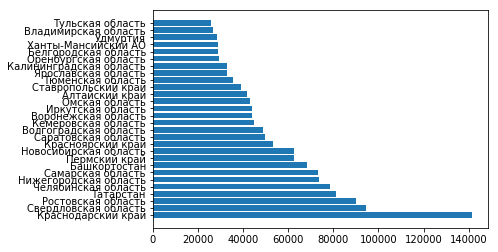

In [7]:
#Regios e seus numeros de anúncios
region_ads_number= df_train['region'].value_counts()
#Guardar os nomes das regiões
regions_names = np.array(region_ads_number.index)
#Guardar os números de anuncios por região.
ads_numbers= np.array(region_ads_number)
#Criar um dataframe com as informações anterios
df_region_ads = pd.DataFrame({'region': regions_names, 'number of ads': ads_numbers})
rank = np.arange(0, len(df_region_ads))
plt.barh(rank, df_region_ads['number of ads'])
plt.yticks(rank, df_region_ads['region'])
plt.show()

Estatísticas sobre Categorias

In [8]:
df_train[['category_name','price','deal_probability']].groupby('category_name').describe()

deal_probability                           \
                                        count      mean       std  min   
category_name                                                            
Автомобили                            62494.0  0.278427  0.297765  0.0   
Аквариум                               4840.0  0.183616  0.282600  0.0   
Аудио и видео                         27036.0  0.171572  0.282541  0.0   
Билеты и путешествия                   3108.0  0.122712  0.229505  0.0   
Бытовая техника                       33705.0  0.252776  0.357260  0.0   
Велосипеды                            10638.0  0.247573  0.345700  0.0   
Водный транспорт                       2180.0  0.229866  0.287619  0.0   
Гаражи и машиноместа                   7304.0  0.119438  0.178737  0.0   
Готовый бизнес                         2028.0  0.099905  0.177439  0.0   
Грузовики и спецтехника                9394.0  0.178480  0.241746  0.0   
Детская одежда и обувь               270359.0  0.060834  0.189678  0.0   
Дома, дачи, коттеджи                  29244.0  0.124862  0.169531  0.0   
Другие животные                       11040.0  0.264051  0.279425  0.0   
Земельные участки                     16038.0  0.088676  0.118045  0.0   
Игры, приставки и программы           11167.0  0.202623  0.294831  0.0   
Квартиры                              83670.0  0.158154  0.206681  0.0   
Книги и журналы                       11819.0  0.040673  0.146976  0.0   
Коллекционирование                    24346.0  0.063719  0.179696  0.0   
Коммерческая недвижимость              8305.0  0.121215  0.152343  0.0   
Комнаты                                8512.0  0.184329  0.239278  0.0   
Кошки                                  9951.0  0.297259  0.309187  0.0   
Красота и здоровье                    29198.0  0.092382  0.220585  0.0   
Мебель и интерьер                     65035.0  0.191848  0.320883  0.0   
Мотоциклы и мототехника                5771.0  0.250694  0.288310  0.0   
Музыкальные инструменты                6695.0  0.190657  0.308390  0.0   
Настольные компьютеры                  5450.0  0.180099  0.285439  0.0   
Недвижимость за рубежом                 117.0  0.053534  0.088808  0.0   
Ноутбуки                              10297.0  0.202596  0.297346  0.0   
Оборудование для бизнеса              16047.0  0.112431  0.221218  0.0   
Одежда, обувь, аксессуары            282753.0  0.046447  0.155944  0.0   
Оргтехника и расходники                6580.0  0.133757  0.256520  0.0   
Охота и рыбалка                        4524.0  0.147584  0.277397  0.0   
Планшеты и электронные книги           8624.0  0.151340  0.260639  0.0   
Посуда и товары для кухни              9076.0  0.103222  0.243745  0.0   
Предложение услуг                     64385.0  0.403123  0.346907  0.0   
Продукты питания                       5781.0  0.135809  0.214250  0.0   
Птицы                                  6447.0  0.238340  0.261208  0.0   
Растения                               9025.0  0.131480  0.230025  0.0   
Ремонт и строительство                56201.0  0.146212  0.274868  0.0   
Собаки                                11612.0  0.252812  0.289535  0.0   
Спорт и отдых                         24881.0  0.146643  0.282449  0.0   
Телефоны                              65944.0  0.186176  0.276068  0.0   
Товары для детей и игрушки            99747.0  0.198445  0.320879  0.0   
Товары для животных                    8580.0  0.133637  0.253146  0.0   
Товары для компьютера                 29565.0  0.162863  0.282458  0.0   
Фототехника                            8345.0  0.132135  0.256945  0.0   
Часы и украшения                      15566.0  0.055316  0.167326  0.0   

                                                                      price  \
                                  25%      50%       75%      max     count   
category_name                                                                 
Автомобили                    0.00000  0.15342  0.625487  0.73760   62494.0   
Аквариум    

In [9]:
#Probabilidade média por categoria
df_train[['category_name','deal_probability']].groupby('category_name').describe()

deal_probability                           \
                                        count      mean       std  min   
category_name                                                            
Автомобили                            62494.0  0.278427  0.297765  0.0   
Аквариум                               4840.0  0.183616  0.282600  0.0   
Аудио и видео                         27036.0  0.171572  0.282541  0.0   
Билеты и путешествия                   3108.0  0.122712  0.229505  0.0   
Бытовая техника                       33705.0  0.252776  0.357260  0.0   
Велосипеды                            10638.0  0.247573  0.345700  0.0   
Водный транспорт                       2180.0  0.229866  0.287619  0.0   
Гаражи и машиноместа                   7304.0  0.119438  0.178737  0.0   
Готовый бизнес                         2028.0  0.099905  0.177439  0.0   
Грузовики и спецтехника                9394.0  0.178480  0.241746  0.0   
Детская одежда и обувь               270359.0  0.060834  0.189678  0.0   
Дома, дачи, коттеджи                  29244.0  0.124862  0.169531  0.0   
Другие животные                       11040.0  0.264051  0.279425  0.0   
Земельные участки                     16038.0  0.088676  0.118045  0.0   
Игры, приставки и программы           11167.0  0.202623  0.294831  0.0   
Квартиры                              83670.0  0.158154  0.206681  0.0   
Книги и журналы                       11819.0  0.040673  0.146976  0.0   
Коллекционирование                    24346.0  0.063719  0.179696  0.0   
Коммерческая недвижимость              8305.0  0.121215  0.152343  0.0   
Комнаты                                8512.0  0.184329  0.239278  0.0   
Кошки                                  9951.0  0.297259  0.309187  0.0   
Красота и здоровье                    29198.0  0.092382  0.220585  0.0   
Мебель и интерьер                     65035.0  0.191848  0.320883  0.0   
Мотоциклы и мототехника                5771.0  0.250694  0.288310  0.0   
Музыкальные инструменты                6695.0  0.190657  0.308390  0.0   
Настольные компьютеры                  5450.0  0.180099  0.285439  0.0   
Недвижимость за рубежом                 117.0  0.053534  0.088808  0.0   
Ноутбуки                              10297.0  0.202596  0.297346  0.0   
Оборудование для бизнеса              16047.0  0.112431  0.221218  0.0   
Одежда, обувь, аксессуары            282753.0  0.046447  0.155944  0.0   
Оргтехника и расходники                6580.0  0.133757  0.256520  0.0   
Охота и рыбалка                        4524.0  0.147584  0.277397  0.0   
Планшеты и электронные книги           8624.0  0.151340  0.260639  0.0   
Посуда и товары для кухни              9076.0  0.103222  0.243745  0.0   
Предложение услуг                     64385.0  0.403123  0.346907  0.0   
Продукты питания                       5781.0  0.135809  0.214250  0.0   
Птицы                                  6447.0  0.238340  0.261208  0.0   
Растения                               9025.0  0.131480  0.230025  0.0   
Ремонт и строительство                56201.0  0.146212  0.274868  0.0   
Собаки                                11612.0  0.252812  0.289535  0.0   
Спорт и отдых                         24881.0  0.146643  0.282449  0.0   
Телефоны                              65944.0  0.186176  0.276068  0.0   
Товары для детей и игрушки            99747.0  0.198445  0.320879  0.0   
Товары для животных                    8580.0  0.133637  0.253146  0.0   
Товары для компьютера                 29565.0  0.162863  0.282458  0.0   
Фототехника                            8345.0  0.132135  0.256945  0.0   
Часы и украшения                      15566.0  0.055316  0.167326  0.0   

                                                                   
                                  25%      50%       75%      max  
category_name                                                      
Автомобили                    0.00000  0.15342  0.625487  0.73760  
Аквариум                      0.00000  0.00000  0.280940

Verificar estatisticas sobre preços

In [10]:
#Histograma preços
round(df_train['price'].describe(),2)

count    1.503424e+06
mean     2.987259e+05
std      6.496484e+07
min      0.000000e+00
25%      4.000000e+02
50%      1.000000e+03
75%      6.000000e+03
max      7.950101e+10
Name: price, dtype: float64

Com base nestas estatísticas categorizamos os preços nas seguintes faixas e extraindos seus datasets a partir do treinamento (df_train).

In [11]:
#Preço alto
df_train_price_EH=df_train.query("price>2.987259e+05")
df_train_price_VH=df_train.query("price>6000.0 and price<=2.987259e+05")
df_train_price_H=df_train.query("price>3000.0 and price<=6000.0") 
df_train_price_M=df_train.query("price>1000.0 and price<=3000.0")
df_train_price_VM=df_train.query("price>500.0 and price<=1000.0") 
df_train_price_L=df_train.query("price>250.0 and price<=500.0")
df_train_price_VL=df_train.query("price>100.0 and price<=250.0")
df_train_price_EL=df_train.query("price<=100.0")

Probabilidade média de cada faixa de preço.

In [12]:
mean_EH=df_train_price_EH['deal_probability'].mean()
mean_VH=df_train_price_VH['deal_probability'].mean()
mean_H=df_train_price_H['deal_probability'].mean()
mean_M=df_train_price_M['deal_probability'].mean()
mean_VM=df_train_price_VM['deal_probability'].mean()
mean_L=df_train_price_L['deal_probability'].mean()
mean_VL=df_train_price_VL['deal_probability'].mean()
mean_EL=df_train_price_EL['deal_probability'].mean()

In [13]:
print('EH:', df_train_price_EH.shape[0], ': ' ,mean_EH )
print('VH:', df_train_price_VH.shape[0], ': ' ,mean_VH )
print('H:', df_train_price_H.shape[0], ': ' ,mean_H )
print('M:', df_train_price_M.shape[0] , ': ' ,mean_M)
print('VM:', df_train_price_VM.shape[0], ': ' ,mean_VM)
print('L:', df_train_price_L.shape[0], ': ' ,mean_L )
print('VL:', df_train_price_VL.shape[0], ': ' ,mean_VL )
print('EL:', df_train_price_EL.shape[0], ': ' ,mean_EL )

number_of_ads==df_train_price_EH.shape[0]+ df_train_price_VH.shape[0]+df_train_price_H.shape[0]\
+df_train_price_M.shape[0]+df_train_price_VM.shape[0]+ df_train_price_L.shape[0]\
+df_train_price_VL.shape[0]+df_train_price_EL.shape[0]

EH: 136490 :  0.12005364993774453
VH: 232453 :  0.18911577213459851
H: 115489 :  0.17770174492807747
M: 254393 :  0.14336922615795566
VM: 225250 :  0.11377824612653116
L: 271408 :  0.10040545643460201
VL: 106643 :  0.08935826402108127
EL: 161298 :  0.1824079884437583


True

### Pre-processamento

Funções auxiliadoras

In [14]:
def setPriceRangeProba(row):
    """Função aplicada em dataFrame com o metodo apply. 
    Dado um anúncio (tupla row), calcula sua probabilidade em função do seu preço e
    da faixa na qual se encontra o mesmo preço.
    Os intervalos foram definidos com base no describe acima.
    Entrada:
        row:tupla do dataframe
    Saída:
        proba: float, probabibilidade, valor entre 0 e 1.
    """
    proba=0.0
    price=row['price']
    if price>2.987259e+05:
        proba=mean_EH
    elif price>6000.0 and price<=2.987259e+05:
        proba=mean_VH
    elif price>3000.0 and price<=6000.0:
        proba=mean_H
    elif price>1000.0 and price<=3000.0:
        proba=mean_M
    elif price>500.0 and price<=1000.0:
        proba=mean_VM
    elif price>250.0 and price<=500.0:
        proba=mean_L
    elif price> 100.0 and price<=250.0:
        proba=mean_VL
    elif price<=100.0:
        proba=mean_EL
    return proba

def setRangePriceCondProba(row):
    """Dado um anúncio (tupla row), calcula sua probabilidade condicional em função do seu preço, 
    da faixa na qual se encontra o mesmo preço, e número de anúncios nesta faixa.
    Os intervalos foram definidos com base no describe acima.
    Entrada:
        row:tupla do dataframe
    Saída:
        probabibilidade: float, valor entre 0 e 1
    """
    prob=0.0
    price=row['price']
    
    if price>2.987259e+05:
        prob=row['priceRangeProbability']*df_train_price_EH.shape[0]/number_of_ads
    elif price>6000.0 and price<=2.987259e+05:
         prob=row['priceRangeProbability']*df_train_price_VH.shape[0]/number_of_ads
    elif price>3000 and price<=6000:
         prob=row['priceRangeProbability']*df_train_price_H.shape[0]/number_of_ads
    elif price>1000 and price<=3000:
         prob=row['priceRangeProbability']*df_train_price_M.shape[0]/number_of_ads
    elif price>500 and price<=1000:
         prob=row['priceRangeProbability']*df_train_price_VM.shape[0]/number_of_ads
    elif price>250 and price<=500:
         prob=row['priceRangeProbability']*df_train_price_L.shape[0]/number_of_ads
    elif price>100 and price<=250:
         prob=row['priceRangeProbability']*df_train_price_VL.shape[0]/number_of_ads
    elif price<=100:
         prob=row['priceRangeProbability']*df_train_price_EL.shape[0]/number_of_ads

    return prob

A reputaçao do anunciante pode influenciar na compra?
Como são apenas 2 anúncios por usuário, descartamos esse parâmetro

In [15]:
df_train[['user_id']].describe()

,user_id
count,1503424
unique,771769
top,45ba3f23bf25
freq,1080


### Configuração das features 
> As features serão configuradas com a função apply do DataFrame utilizando as funções auxiliadoras e outras que serão definidas mais adiante.

Consideramos as features como métricas numéricas:  probabilidades médias, preços e frequências de tipo de usuários. Essas métricas derivam das informações contidas nos anúncios. Para sua extração os anúncios são agrupados (Groupby), e através do metodo apply do DataFrame cria-se colunas derivadas tanto no dataframe do treinamento(train.csv) e quanto no dataframe submissão(test.csv)

A seguir definimos essas funções auxiliadoras.

In [16]:
def setUserTypeProb(row):
    """Função aplicada ao dataFrame com método apply. 
    Calcula a probabilidade média por tipo de usuário (user_type).
    Entrada:
        row:tupla do dataframe
    Saída:
        mean_prob: float. Probabilidade média de um tipo de usuário.
    """
    mean_prob=0.0
    user_type=str(row['user_type'])
    if user_type=="Shop":
        mean_prob=0.062829
    elif user_type=="Private":
        mean_prob=0.149557
    elif user_type=="Company":
        mean_prob=0.124513
    return mean_prob

def setUserTypeProp(row):
    """Função aplicada ao dataFrame. 
    Calcula a frequência de um tipo de usuário (user_type) pela sua frequência em anúncios
    a partir dos dados obtidos na exploração do treinamento.
    Entrada:
        row:tupla do dataframe
    Saída:
        nova coluna no dataFrame
    """
    prop=0.0
    user_type=str(row['user_type'])
    if user_type=="Shop":
        prop=0.053524
    elif user_type=="Private":
        prop=0.715504
    elif user_type=="Company":
        prop=0.230972
    return prop

def groupByEntityMeanAttr(entity, attribute='deal_probability'):
    """Extrai um dataframe do dataset do train_csv contendo duas colunas,
    e realiza o agrupamento do mesmo por uma das colunas.
    Calcula a probabilidade média por agrupamento.
    Entrada:
        entity: coluna pelo qual o agrupamento será realizado
        attrubute: coluna pela qual a média será calculada (float), 
        sendo 'deal_probability' o default.
    Saída:
        dataframe com dados agrupados segundo entity, cada grup tendo sua média.
    """
    return df_train[[entity,attribute]].groupby(entity).mean()

def getDictEntityMeanByGrp(grp_entity):
    """ Encapsula a foncionalidade de mapear os agrupamentos às suas probabilidades médias.
    Entrada:
        grp_entity: dataframe em agrupamento segundo uma coluna, cada agrupamento com sua média.
    Saída:
        dic_entity_proba: dicionário, com nome do grupo como chave e probabilidade média como valor.
    """
    dic_entity_proba={}
    for row in grp_entity.itertuples():
        #Exemplo: Formato ('entity', deal_probability)
        str1=str(row[0]) 
        #Remover parenteses
        str2=str1.replace('(','')
        str3=str2.replace(')','')
        #Particionar em tokens separados por uma virgula: ,
        str4=str3.split(',')
        #Primeiro token é entity
        entity=str4[0]
        
        #Probabilidade é mais simples de extrair
        #dic_entity_proba[entity]=row.deal_probability
        #Probabilidade é mais simples de extrair
        attribute_value=row[1]
        dic_entity_proba[entity]=attribute_value
    return dic_entity_proba

#Retorna a probabilidade média do user
#def setCityPrice(row,attribute):
def setCityPrice(row):
    """Função Usada em DataFrame com função apply para determinar o preço medio
    do anúncio em uma cidade.
    Entrada:
        row:tupla do DataFrame
    Saída:
        meanPrice: float. Preço médio do anúncio na cidade.   
    """
    key=str(row['city'])
    meanPrice=0.0
    if key in dic_city_meanPrice.keys():
        meanPrice=dic_city_meanPrice[key]
    return meanPrice

def setCityProba(row):
    """Função Usada em DataFrame com função apply para determinar aprobabilidade média
    do anúncio em uma cidade.
    Entrada:
        row:tupla do DataFrame
    Saída:
        prob: float. Probabilidade média do anúncio na cidade.   
    """
    key=str(row['city'])
    prob=0.0
    if key in dic_city_meanPrice.keys():
        prob=dic_city_meanPrice[key]
    return prob

def setEntityProba(row,entity='o', dic_entity=None):
    """
    Entrada:
    Saída:
    """
    key=str(row[entity])
    prob=0.0
    if key in dic_entity.keys():
        prob=dic_entity[key]
    return prob

def setEntityPrice(row,entity='o', dic_entity=None):
    """
    Entrada:
    Saída:
    """
    key=str(row[entity])
    price=0.0
    if key in dic_entity.keys():
        price=dic_entity[key]
    return price

def setEntityCondProba(row,entity_1=None, entity_2=None):
    """Função aplicada em cada tupla do DataFrame para calcula a probabilidade de um anúncio (row) 
    com base em duas probabilidades informadas. 
    Entrada:
        row:tupla do DataFrame no qual a função é aplicada com 'apply'.
        entity_1: nome coluna do DataFrame, string. Necessária para ter o valor da probalidade da tupla.
        entity_2: nome coluna do DataFrame, string. Necessária para ter o valor da probalidade da tupla.
    Saída:
    """
    return row[entity_1]*row[entity_2]

def groupByEntitySumAttr(entity, attribute='deal_probability'):
    """Gera um dataframe a partir do treino (df_train) agregando segundo a coluna informada (entity),
    Soma a quantidade e tuplas em cada grupo.
    Entrada:
        entity:coluna do df_train pelo qual o agrupamento é realizado.Ideal que seja uma categoria como 'region' ou 'user_type'.
        attribute: outra coluna do dataframe df_train. Opcional. 
    Saída:
        dataframe contendo agregamento com soma cada subgrupo.
    """
    df_entity=df_train[[entity]]
    df_entity['occorence']=1
    return df_entity.groupby(entity).sum()


def setEntityProbaByNumber(row, entity=None, dic_entity=None):
    """Função Usada em DataFrame com função apply para colunas (entity) 
    que tem categorias como user_type para determinar a probabilidade/frequência de cada categoria. 
    por uma coluna(entity) como 'region' ou 'user_type'.
    Cada grupo contem uma única métrica, Ex.: mean ou sum.
    Entrada:
        row:tupla do DataFrame
        dic_entity:dicionário das categorias, cada uma com uma métrica.
    Saída:
        prob: probabilidade, frequência, float entre 0.0 e 1.0 .   
    """
    prob=0.0
    key=row[entity]
    if key in dic_entity.keys():
        prob=dic_entity[key]/number_of_ads
    return prob

def getDictEntityByGrp(grp_entity):
    """Gera um dicionário com base em um dataframe contendo elementos agrupados 
    por uma coluna(entity) como 'region' ou 'user_type'.
    cada grupo contem uma única métrica, Ex.: mean ou sum.
    Entrada:
        grp_entity:dataframe gerado por um grouby em uma coluna.
    Saída:
        dic_entity: dicionário no formato "nome do grupo:métrica". 
    """
    dic_entity={}
    for row in grp_entity.itertuples():
        entity=row[0]
        attribute_value=row[1]
        dic_entity[entity]=attribute_value
    return dic_entity

Criação de agrupamentos(groupby) e dicionários usados para configurar as features nos dataframes do treino e submissão. São usados nas funções definidas acima.

In [17]:
#user reputation
#grp_user_meanProba=groupByEntityMeanAttr('category_name')
#dic_category_meanProba=getDictEntityMeanByGrp(grp_category_meanProba)
#userType

#features sobre category_name
grp_category_meanProba=groupByEntityMeanAttr('category_name')
dic_category_meanProba=getDictEntityMeanByGrp(grp_category_meanProba)
grp_category_sum=groupByEntitySumAttr('category_name')
dic_ads_number_by_category=getDictEntityByGrp(grp_category_sum)

#features sobre city
grp_city_meanPrice=groupByEntityMeanAttr('city', attribute='price')
dic_city_meanPrice=getDictEntityMeanByGrp(grp_city_meanPrice)
#grp_city_MeanPrice.describe()
grp_city_meanProba=groupByEntityMeanAttr('city')
dic_city_meanProba=getDictEntityMeanByGrp(grp_city_meanProba)
#grp_city_MeanProba.describe()

#region
grp_region_meanProba=groupByEntityMeanAttr('region')
dic_region_meanProba=getDictEntityMeanByGrp(grp_region_meanProba)
grp_region_sum=groupByEntitySumAttr('region')
dic_ads_number_by_region=getDictEntityByGrp(grp_region_sum)
#grp_region_MeanPrice.describe()

grp_prtCategory_meanProba=groupByEntityMeanAttr('parent_category_name')
dic_prtCategory_meanProba=getDictEntityMeanByGrp(grp_prtCategory_meanProba)
#grp_prtCategory_MeanProba.describe()

### Descrições das features:
São novas colunas configuradas nos dataframes do treinamento e submissão com o método apply.  Usa-se uma função auxiliadora a seguir para encapsular essa operação.

Features:
* user_type_freq: frequência/proporção do tipo de usuário (Private, Company ou Shop) nos anúncios
* user_type_prob: probabibilidade média por tipo de usuário.
* user_type_condProb: Probabilidade condicional sobre o tipo de usuário em função da quantidade de usúario por tipo (frequência) e a probabilidade média por tipo de usuário (Private, Company ou Shop).
* category_prob': Probabilidade média de uma categoria (category_name).
* price: Preço do anúncio. 
* city_price': Preço médio do anúncio em uma cidade.        
* priceRangeCondProb': Probabilidade média do anúncio com base na sua faixa do seu preço
* city_probability':probabilidade média do anúncio em uma cidade.
* region_probability:probabilidade média do anúncio em uma region.

In [18]:
def applyFeatures(df):
    '''Configura as features em um dataframe (treinamento/ou submissão)
    Entrada:
        df: dataframe
    Saída:
        derived_df: mesmo dataframe da entrada com as features configuradas.
    '''
    derived_df=df
    #derived_df['category_prob']=derived_df.apply(setCategoryProb, axis=1)
    derived_df['user_type_freq']    =derived_df.apply(setUserTypeProp, axis=1)
    derived_df['user_type_prob']    =derived_df.apply(setUserTypeProb, axis=1)
    derived_df['user_type_condProb']=derived_df.apply(setEntityCondProba,  entity_1='user_type_freq',\
                                                    entity_2='user_type_prob',axis=1)

    derived_df['priceRangeProbability']=derived_df.apply(setPriceRangeProba, axis=1)
    derived_df['priceRangeCondProb']   =derived_df.apply(setRangePriceCondProba, axis=1)
    derived_df['category_prob']        =derived_df.apply(setEntityProba, entity='category_name', 
                                                  dic_entity=dic_category_meanProba, axis=1)
    derived_df['category_freq']       =derived_df.apply(setEntityProbaByNumber, entity='category_name', 
                                                  dic_entity=dic_ads_number_by_category, axis=1)
    derived_df['category_condProb']   =derived_df.apply(setEntityCondProba,  entity_1='category_freq',\
                                                    entity_2='category_prob',axis=1)
    derived_df['region_probability'] = derived_df.apply(setEntityProba, entity='region', 
                                                  dic_entity=dic_region_meanProba, axis=1)
    derived_df['region_freq'] = derived_df.apply(setEntityProbaByNumber, entity='region', 
                                                  dic_entity=dic_ads_number_by_region, axis=1)
    derived_df['region_condProb']=derived_df.apply(setEntityCondProba,  entity_1='region_freq',\
                                                    entity_2='region_probability',axis=1)

    derived_df['city_probability'] = derived_df.apply(setEntityProba, entity='city', 
                                                  dic_entity=dic_city_meanProba, axis=1)
    derived_df['city_price'] = derived_df.apply(setEntityPrice, entity='city', 
                                                  dic_entity=dic_city_meanPrice, axis=1)

    #derived_df['prt_category_probability'] = derived_df.apply(setEntityProba, entity='parent_category_name', 
    #                                            dic_entity=dic_prtCategory_meanProba, axis=1)
    return derived_df

Antes de aplicar essas features nos dataframes precisamos verificar a distribução das probabilidades.
Devido à limitações dos nossos computadores pessoais, não foi possivel processar os modelos de regressão e classificação no dataframe inteiro do treinamento. Contornamos isso trabalhando com amostra de dados representativa quanto à distribução das probabilidades.

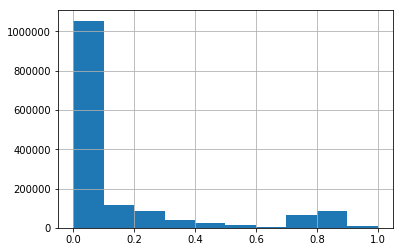

In [19]:
df_train['deal_probability'].hist()

Vamos categorizamos as probabilidades para extrair uma amostra representativa em função das probabilidades do dataset do treinamento, df_train. Para tanto usamos tambem função auxiliadora.

In [20]:
def getRepresentativeSample(df, size=60000):
    '''Obter uma amostra representativa do dataframe com base nas probabilidades
    Entrada:
        df:dataframe
        size:tamanho da amostra.
    Saída:
        df_sample: amostra, dataframe
    '''
    df_P1=df.query("deal_probability>=0.70") 
    df_P2=df.query("deal_probability>=0.60 and deal_probability<0.70")
    df_P3=df.query("deal_probability>=0.50 and deal_probability<0.60") 
    df_P4=df.query("deal_probability>=0.35 and deal_probability<0.50") 
    df_P5=df.query("deal_probability>=0.25 and deal_probability<0.35") 
    df_P6=df.query("deal_probability<0.25") 
    #Percentuais por categoria
    number_of_ads_=df.shape[0]
    perc_P1=len(df_P1.index)/number_of_ads_
    perc_P2=len(df_P2.index)/number_of_ads_
    perc_P3=len(df_P3.index)/number_of_ads_
    perc_P4=len(df_P4.index)/number_of_ads_
    perc_P5=len(df_P5.index)/number_of_ads_
    perc_P6=len(df_P6.index)/number_of_ads_
    
    #Tamanho por categoria
    P1_size=int(perc_P1*size)
    P2_size=int(perc_P2*size)
    P3_size=int(perc_P3*size)
    P4_size=int(perc_P4*size)
    P5_size=int(perc_P5*size)
    P6_size=size-(P1_size+P2_size+P3_size+P4_size+P5_size)
    
    #Extrair amostra de cada categoria
    df_P1_=df_P1.sample(n=P1_size, random_state=random.randint(1,P1_size))
    df_P2_=df_P2.sample(n=P2_size, random_state=random.randint(1,P2_size))
    df_P3_=df_P3.sample(n=P3_size, random_state=random.randint(1,P3_size))
    df_P4_=df_P4.sample(n=P4_size, random_state=random.randint(1,P4_size))
    df_P5_=df_P5.sample(n=P5_size, random_state=random.randint(1,P5_size))
    df_P6_=df_P6.sample(n=P6_size, random_state=random.randint(1,P6_size))

    #Unir os conjunto de anúncios em df: 6 categorias
    df_sample=pd.concat([df_P1_, df_P2_, df_P3_, df_P4_, df_P5_, df_P6_], axis=0)
    return df_sample

Para o treinamento extraimos uma amostra representativa de 60000 anúncios.
E configuramos as features nela com a função auxiliadora applyFeatures.

In [21]:
sample_size=90000
df_sample_=getRepresentativeSample(df_train, size=sample_size)
df_sample=applyFeatures(df_sample_)
print('sample size :', df_sample.shape)
df_sample.head(1)

sample size : (90000, 31)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,priceRangeProbability,priceRangeCondProb,category_prob,category_freq,category_condProb,region_probability,region_freq,region_condProb,city_probability,city_price
467054,b8573e361bc3,3bd8004cca24,Самарская область,Самара,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Верхняя одежда,42–44 (S),Джинсовая куртка,...,0.113778,0.017047,0.0,0.188073,0.0,0.136721,0.048827,0.006676,0.1394,237922.073887


Para o cross-validation do treinamento extraimos uma amostra representativa. E configuramos as features nela com a função auxiliadora applyFeatures.

In [22]:
cross_val_size=30000
df_cross_val_=getRepresentativeSample(df_train, size=cross_val_size)
df_cross_val=applyFeatures(df_cross_val_)
print('Size', df_cross_val_.shape)
#df_cross_val.head(1)

Size (30000, 31)


Para a submissão configuramos apenas as features com a função auxiliadora applyFeatures.

In [23]:
df_test_=applyFeatures(df_test)

In [24]:
#Limpamos a memoria
del df_cross_val_, df_sample_, df_test
gc.collect()

197

### Features extração
Com as features configuramos extraimos apenas aquelas que tiveram ter melhores scores no Kaggle. Extraimos para:
* Treinamento: X
* Cross Validation: X_cv
* Submission: X_submission

In [25]:
#USO DE TODAS AS FEATURES
"""
X=df_sample[['user_type_freq', 'user_type_prob', 'user_type_condProb','category_prob','user_type_condProb', 'price', 'city_price',
             'priceRangeProbability','city_probability','region_probability',
             'prt_category_probability']].values
#para submission
X_submission=df_test_[['user_type_freq', 'user_type_prob', 'user_type_condProb','category_prob', 'price', 
             'priceRangeProbability','city_probability','region_probability',
                      'prt_category_probability']].values
"""
#USO DE ALGUMAS FEATURES
##7features
X=df_sample[['user_type_condProb', 'category_prob', 'price', 'city_price',
             'priceRangeCondProb','city_probability','region_probability'
             ]].values

df_sample[['user_type_condProb', 'category_prob', 'price', 'city_price',
             'priceRangeCondProb','city_probability','region_probability']].head(2)


,user_type_condProb,category_prob,price,city_price,priceRangeCondProb,city_probability,region_probability
467054,0.107009,0.000000,1000.0,237922.073887,0.017047,0.139400,0.136721
1313334,0.028759,0.403123,0.0,267562.359528,0.019570,0.118559,0.124193


In [26]:
#For cross validation
X_cv=df_cross_val[['user_type_condProb', 'category_prob', 'price', 'city_price',
             'priceRangeCondProb','city_probability','region_probability']].values
df_cross_val[['user_type_condProb', 'category_prob', 'price', 'city_price',
             'priceRangeCondProb','city_probability','region_probability']].head(2)

,user_type_condProb,category_prob,price,city_price,priceRangeCondProb,city_probability,region_probability
593548,0.107009,0.162863,2000.0,145440.689639,0.024259,0.135031,0.142602
841477,0.107009,0.000000,300.0,171913.650930,0.018126,0.139019,0.143229


In [27]:
#para submission
X_submission=df_test_[['user_type_condProb', 'category_prob', 'price', 'city_price',
             'priceRangeCondProb','city_probability','region_probability']].values

print('Train Predict: ',X.shape,'; Cross Validation: ',X_cv.shape,'; Submission: ', X_submission.shape)
#df_test[['user_type_condProb', 'category_prob', 'price', 'city_price',
#             'priceRangeCondProb','city_probability','region_probability']].head(2)

Train Predict:  (90000, 7) ; Cross Validation:  (30000, 7) ; Submission:  (508438, 7)


Extração dos targets:
* Treinamento: y
* cross validation: y_cv

Observação: para a submissão os targets serão estimados.

In [28]:
y=df_sample['deal_probability'].values 
y_cv=df_cross_val['deal_probability'].values  
print(y.shape, y_cv.shape)

(90000,) (30000,)


In [29]:
del df_sample, df_cross_val
gc.collect()

80

Para o treinamento, extraimos parte das features e target para o treinamento em se e outra parte para os testes.

In [30]:
#Embaralhar, antes de selecionar
seed_=random.randint(1,sample_size)
np.random.seed(seed_)
np.random.shuffle(X)

np.random.seed(seed_)
np.random.shuffle(y)

train_sample_size=int(sample_size*0.7)
n=train_sample_size 
#features and targets for trains
X_train=X[:n]
y_train=y[:n]
#features and targets for tests
X_test=X[n:]
y_test=y[n:]

In [31]:
#Liberar memoria
#del dic_user_proba, dic_categories, company_mean_grp
#del grp_city_meanProba, grp_city_meanPrice, grp_region_meanProba, grp_prtCategory_meanProba
#del dic_city_meanProba, dic_city_meanPrice, dic_region_meanProba, dic_prtCategory_meanProba
gc.collect()

0

Os targets são valores contínuos entre 0 e 1 (deal_probability). Trata-se de uma problema de regressão. No entanto, tentaremos realizar a previsão usando tanto a regressão quanto a classificação.

Passos:

1. Treinamento e avaliação dos algoritmos de regressão
2. Treinamento e avaliação dos algoritmos de regressão
3. Comparação com cross validação
4. Realização da predição do submission


### 1.  Treinamento e avaliação dos algoritmos de regressão

#### 1.1. SVR

In [32]:
gc.collect()

0

In [33]:
#Instanciar e treinar
clf=None
clf=SVR(cache_size=4000)
clf.fit(X_train, y_train)
joblib.dump(clf,'svr_7feats.pkl')
clf

SVR(C=1.0, cache_size=4000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [34]:
#Realiza o fit quebrando em bloco
def performPrediction(X_submission_,clf_, number=25000):
    """Realiza o predict de um modelo processando as features em blocos.
    Usa um principio semelhante ao "dividir para conquistar"  para acelerar o processamento.  
    No final junta a sáida de cada bloco no resultado.
    Entrada:
        X_submission_: labels, matriz de features numpy.array.
        number: número de linha de cada bloco, 25000 por default
    Saída:
        y: targets (probabilidades codificadas ou não),  no formato 1-D array.
    """
    X_submission_list=[]
    min=0
    max=number
    add=number
    
    for i in range(0,20):
        X_submission_list.append(X_submission_[min:max])
        #print('min=',min,'max=', max)
        min+=add
        max+=add
        
    
    max=X_submission_.shape[0]
    #print(min, max)
    if min!=max:
        X_submission_list.append(X_submission_[min:])
        
    #print(len(X_submission_list))
    
    y_hat_encoded_parts=[]
    for i in range(0,len(X_submission_list)):
        y_hat_encoded_parts.append(pd.Series(clf_.predict(X_submission_list[i])))
    
    y_hat_encoded=pd.concat((y_hat_encoded_parts[0],y_hat_encoded_parts[1],y_hat_encoded_parts[2],\
                        y_hat_encoded_parts[3],y_hat_encoded_parts[4],y_hat_encoded_parts[5],\
                        y_hat_encoded_parts[6],y_hat_encoded_parts[7],y_hat_encoded_parts[8],\
                        y_hat_encoded_parts[9],y_hat_encoded_parts[10],y_hat_encoded_parts[11],\
                        y_hat_encoded_parts[12],y_hat_encoded_parts[13],y_hat_encoded_parts[14],\
                        y_hat_encoded_parts[15],y_hat_encoded_parts[16],y_hat_encoded_parts[17],\
                        y_hat_encoded_parts[18],y_hat_encoded_parts[19],y_hat_encoded_parts[20],\
                             ),axis=0)
    return y_hat_encoded.values


* Criar dataframe com as demandas/probabilidades previstas e as estimadas pelo classificador
* Aplicar a função em cada tupla para obter a variancia da probabilidade estimada.
* calcular a variancia e desvio padrão considerando a media da amostra. 
* Desvio está baixo?

In [35]:
def predicAndEvaluate(clf_,X_test_,y_test_):
    """
    Enpasula o processo de previsão e avaliação para classificdores.
    Entrada:
        clf_:classificador
        X_test_: matriz de features, N-Dimensional array
        y_test_: targets esperados (probabilidades) .
    Saída:
        std_:desvio
    """

    #Realizar o predict em blocos, matrizes de 300 linhas
    y_hat_=clf_.predict(X_test_)
    #print('y_hat after', y_hat_[:10]) #Para teste
    #AVALIAR
    
    df_proba_= pd.DataFrame({'expected_deal_probality': y_test_,
                         'predicted_deal_probality': y_hat_})
    #Cria-se uma nova coluna no df
    df_proba_['desvio'] = df_proba_.apply(setVariance, axis=1)
    tamanho=len(df_proba_.index)
    std_=1000
    if tamanho!=0:
        std_=np.sqrt(df_proba_[['desvio']].sum()/tamanho)
    
    print('Mean Squared error: ', mean_squared_error(y_hat_,y_test_))
    print('Desvio baixo? ', std_)
    #print(df_proba_.head())

def setVariance(row):
    """Calcular a variancia de qualquer probalidade estimada.
    Função auxiliar usada para avaliar as técnicas
    Entrada:
        row:tupla de dataframe
    Saída:
        variancia:float
    """
    return (row['predicted_deal_probality']-row['expected_deal_probality'])**2


In [36]:
#prever
predicAndEvaluate(clf,X_test,y_test)

Mean Squared error:  0.07114101539368442
Desvio baixo?  desvio    0.266723
dtype: float64


### 1.2 Regressão Linear 


In [37]:
#Instanciar e treinar
clf=None
clf = LinearRegression()
clf.fit(X_train, y_train)
joblib.dump(clf,'lreg_7feats.pkl') 
clf

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
#prever
predicAndEvaluate(clf,X_test,y_test)

Mean Squared error:  0.058684996608251286
Desvio baixo?  desvio    0.24225
dtype: float64


#### 1. 3 SGDRegressor

In [39]:
#Limpar a memoria do treino
gc.collect()

26

In [40]:
from sklearn.linear_model import SGDRegressor
clf=None 
clf = SGDRegressor()
clf.fit(X_train, y_train)
joblib.dump(clf,'sgdr_7feats.pkl')
clf

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [41]:
predicAndEvaluate(clf,X_test,y_test)

Mean Squared error:  4.403810518137804e+43
Desvio baixo?  desvio    6.636121e+21
dtype: float64


#### 1.4. Previsão usando Multi-layer Perceptron Regressor
This model optimizes the squared-loss using LBFGS or stochastic gradient descent.

http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

One hidden layer

In [42]:
#Limpar a memoria do treino
gc.collect()

26

In [43]:
#Instanciar e treinar
clf=None 
clf = MLPRegressor(hidden_layer_sizes=(1,))
clf.fit(X_train, y_train)
joblib.dump(clf,'mlpr_7feats_1.pkl')
clf

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [44]:
#prever
predicAndEvaluate(clf,X_test,y_test)

Mean Squared error:  0.06740137544781799
Desvio baixo?  desvio    0.259618
dtype: float64


### 2. Treinamento e avaliação da classificação

Como os targets são valores continuos é necessário codifica-los para valores discretos, pois a classificação não é viável com valores continuos. Senão um erro ocorre no classificador MNBayes.
>Primeiro, verificamos que o array os targets são realmente valores contínuos, que são ideais para a regressão. 

In [45]:
print(utils.multiclass.type_of_target(y_test))

continuous


Instanciamos um codificador e transformamos os valores contínuos em valores discretos.

In [46]:
lab_enc = preprocessing.LabelEncoder()
#Encoded armazena valores discretos
y_train_encoded = lab_enc.fit_transform(y_train)
print(utils.multiclass.type_of_target(y_train_encoded))

multiclass


#### 2.1 Multinomial Naive Bayes

In [47]:
#Instanciando o codificador
lab_enc = preprocessing.LabelEncoder()
def getEncoded(y_train_):
    """Realiza a codificação de targets de valores contínuo para valores discretos.
    Necessário para a classificaçao.
    Entrada:
        y_train_: targets (probabilidades), array de floats de uma dimensão.
    Saída:
        y_train_encoded_: targets codificados.
    """
    y_train_encoded_ = lab_enc.fit_transform(y_train_)
    print(utils.multiclass.type_of_target(y_train_encoded_))
    return y_train_encoded_

def getInverse_transform(y_hat_encoded_):
    """Realiza o processo inverso da função getEncoded. 
    Converte os targets codificados para seus targets originais (probabilidades).
    Necessário para a classificaçao.
    Entrada:
        y_train_: targets (probabilidades), array de floats de uma dimensão.
    Saída:
        y_train_encoded_: targets codificados.
    """
    return lab_enc.inverse_transform(y_hat_encoded_)

def predicAndEvaluateClas(clf_,X_test_,y_test_,encoder):
    """
    Enpasula o processo de previsão e avaliação para classificdores.
    Entrada:
        clf_:classificador
        X_test_: matriz de features, N-Dimensional array
        y_test_: targets esperados (probabilidades) .
    Saída:
        std_:desvio
    """
    lab_enc_=encoder
    #Realizar o predict em blocos, matrizes de 300 linhas
    y_hat_encoded_=performPrediction(X_test_,clf_, number=300)
    #Converter para os target do dominio: 0 a 1
    y_hat_=lab_enc_.inverse_transform(y_hat_encoded_)
    #print('y_hat after', y_hat_[:10])
    #AVALIAR
    df_proba_= pd.DataFrame({'expected_deal_probality': y_test_,
                         'predicted_deal_probality': y_hat_})
    #Cria-se uma nova coluna no df
    df_proba_['desvio'] = df_proba_.apply(setVariance, axis=1)
    tamanho=len(df_proba_.index)
    std_=1000
    if tamanho!=0:
        std_=np.sqrt(df_proba_[['desvio']].sum()/tamanho)
    
    print('Mean Squared error: ', mean_squared_error(y_hat_,y_test_))
    print('Desvio baixo? ', std_)
    #print(df_proba_.head())

In [48]:
lab_enc = preprocessing.LabelEncoder()
#Encoded armazena valores discretos
y_train_encoded = lab_enc.fit_transform(y_train)

In [49]:
#Limpar a memoria do treino
gc.collect()

351

In [50]:
#Instanciar e treinar
clf=None
clf = MultinomialNB(alpha=0.1) 
#Fit com target codificados
clf.fit(X_train, y_train_encoded)
joblib.dump(clf,'mnb_7feats.pkl') 
clf

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [51]:
#Previsão e avaliação
predicAndEvaluateClas(clf,X_test,y_test,lab_enc)

Mean Squared error:  0.16988206523047666
Desvio baixo?  desvio    0.412168
dtype: float64


### 2.2.Multi-layer Perceptron classifier.

This model optimizes the log-loss function using LBFGS or stochastic gradient descent.

In [52]:
#Instanciar e treinar
clf=None 
clf = MLPClassifier(hidden_layer_sizes=(1, ))
clf.fit(X_train, y_train_encoded)
joblib.dump(clf,'mlpc_7feats_hiden1.pkl')
clf

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [53]:
predicAndEvaluateClas(clf,X_test,y_test, lab_enc)

Mean Squared error:  0.08630765675460539
Desvio baixo?  desvio    0.293782
dtype: float64


### 1.3 GaussianNB

In [54]:
#Instanciar e treinar
clf=None
clf =  GaussianNB()
clf.fit(X_train, y_train_encoded)
joblib.dump(clf,'gnBayes_7feats.pkl')
clf

GaussianNB(priors=None)

In [55]:
#Previsão e avaliação
predicAndEvaluateClas(clf,X_test,y_test, lab_enc)

Mean Squared error:  0.18926102926214952
Desvio baixo?  desvio    0.435041
dtype: float64


#### 1.4 SVC

In [56]:
gc.collect()

52

clf=None 
clf = SVC(cache_size=4000)
clf.fit(X_train, y_train_encoded)
joblib.dump(clf,'svc_7feats.pkl')
clf

#Previsão e avaliação
predicAndEvaluateClas(clf,X_test,y_test, lab_enc)

### 3. Comparação dos metodos com cross-validation
O uso do cross-validation está descrito em http://scikit-learn.org/stable/modules/cross_validation.html

In [57]:
from sklearn.model_selection import cross_validate, cross_val_score

def getScores(clf_, X_tr, y_tr, k=10, 
                  scoring=['neg_mean_squared_error'], rt_tr=False):
    '''Realiza o treinamento e a validação, utilizando o cross-validation, e calcula as métricas desejadas
    
    Entrada:
        clf: Classificador a ser treinado
        X_train: Conjunto de dados de treinamento
        y_train: Classificações de cada exemplo do conjunto de dados
        k: Quantidade de folds a serem usados na cross-validation; a cada iteração (k-1) folds 
            são usados para treino e o fold remanescente é utilizado para validação
        scoring: Lista de métricas a serem calculadas para cada iteração da cross-validation
        rt_train: Decide se as métricas calculadas para o conjunto de treinamento são retornadas ou não
        
    Saída:
        scores: Dicionário contendo as métricas de cada iteração da cross-validation
        
    '''
    scores = cross_validate(clf_, X_tr, y_tr, cv=k, scoring=scoring, return_train_score=rt_tr)        
    return scores

In [58]:
import warnings
warnings.filterwarnings('ignore')

def plot_metric(clf_scores, metrics, imgname='reg.png'):
    '''Plota métricas específicas para os diversos classificadores empregados.
    
    Entrada:
        clf_scores: Dicionário com as métricas dos classificadores
        metrics: Métricas a serem plotadas
        
    Saída:
        Gráfico com as métricas exibido na célula de saída
    '''
    
    for i, metric in enumerate(metrics):
        plt.figure()
        for score in clf_scores:
            x = range( len( clf_scores[score][metric]) )
            y = clf_scores[score][metric]*100
            plt.subplot(len(metrics),1,i+1)
            plt.plot(x, y, alpha=0.3)
            plt.scatter(x, y, label='{0}, média: {1}'.format(score, round(y.mean(),2)))
            plt.xticks(x)
            plt.xlabel('iteração', fontsize='large')
            plt.title('{0} na validação'.format(metric.split('_')[1]),  fontsize='large')
            plt.legend(loc='best', fontsize='large')
            plt.grid('on')
    plt.savefig(imgname)
    plt.show()

### 3.1 Regressões

Regressão linear 

In [59]:
lreg=LinearRegression()
score_lreg=getScores(lreg, X_cv, y_cv)
score_lreg

{'fit_time': array([0.04690337, 0.        , 0.01557064, 0.        , 0.01562405,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01562357, 0.        , 0.        ]),
 'test_neg_mean_squared_error': array([-0.50544537, -0.07807793, -0.02003695, -0.02007576, -0.02032257,
        -0.02141313, -0.02050097, -0.02051267, -0.01981619, -0.0212711 ])}

SVR

In [60]:
svr=SVR(cache_size=4000)
score_svr=getScores(svr, X_cv, y_cv)
score_svr

{'fit_time': array([ 95.06525421, 132.37477922, 133.49833703, 114.33591866,
        113.8620162 , 129.58632708, 113.12200856, 133.87337852,
        132.23089147, 113.66147089]),
 'score_time': array([2.19923615, 2.41652942, 2.8089745 , 2.88204741, 2.81923294,
        2.80795598, 2.91077709, 2.94731808, 2.8084116 , 2.8071022 ]),
 'test_neg_mean_squared_error': array([-0.48514791, -0.10112094, -0.02299539, -0.02577542, -0.02336484,
        -0.02550251, -0.02305601, -0.02388804, -0.02342548, -0.02204213])}

MLPRegressor

In [61]:
gc.collect()
mlpr=MLPRegressor(hidden_layer_sizes=(1,))

In [62]:
score_mlpr=getScores(mlpr, X_cv, y_cv)
score_mlpr

{'fit_time': array([4.91726017, 1.85355878, 2.16735411, 0.60253763, 2.46158576,
        4.84972119, 0.42187142, 0.28123403, 1.91523576, 0.23775077]),
 'score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'test_neg_mean_squared_error': array([-1.77374709, -2.53217139, -0.99035309, -0.01993545, -9.4555763 ,
        -0.01690495, -0.0185919 , -0.01902189, -4.44328028, -0.06991511])}

In [63]:
sgdr=SGDRegressor()

In [64]:
score_sgdr=getScores(sgdr, X_cv, y_cv)
score_sgdr

{'fit_time': array([0.01562548, 0.015625  , 0.01562524, 0.01562452, 0.01562524,
        0.01562214, 0.01562524, 0.01562452, 0.02479029, 0.01601076]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.01562786,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'test_neg_mean_squared_error': array([-1.19534351e+47, -1.23390944e+47, -2.64975309e+40, -1.61906586e+42,
        -7.26861811e+48, -1.85241994e+42, -1.32729792e+42, -8.69680748e+44,
        -3.62567973e+47, -4.55913101e+45])}

Visualizar as compações entre os modelos

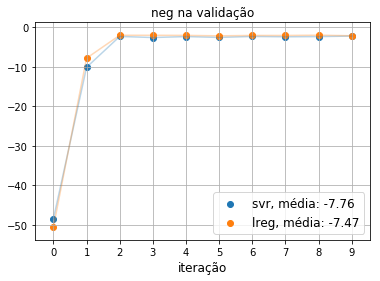

In [65]:
scores=None
scores={}
scores['svr']=score_svr
scores['lreg']=score_lreg
#scores['mlpr']=score_mlpr
#Visualizar
plot_metric(scores, ['test_neg_mean_squared_error'])

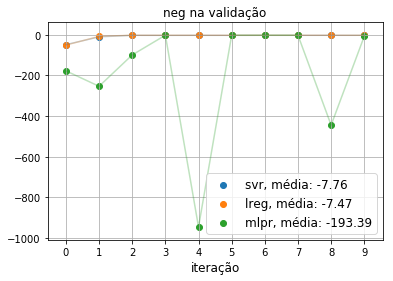

In [66]:
scores=None
scores={}
scores['svr']=score_svr
scores['lreg']=score_lreg
scores['mlpr']=score_mlpr
#Visualizar
plot_metric(scores, ['test_neg_mean_squared_error'],imgname='reg_mlpr.png')

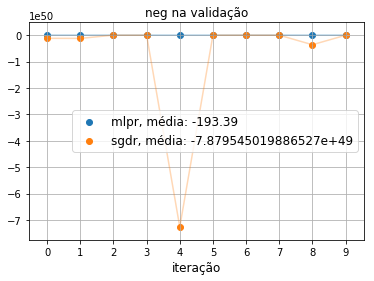

In [67]:
scores=None
scores={}
scores['mlpr']=score_mlpr
scores['sgdr']=score_sgdr
#Visualizar
plot_metric(scores, ['test_neg_mean_squared_error'],imgname='r_sgdr_mlpr.png')

### 3.2 Classificação

In [68]:
#Para os fit dos classificadores é codificar as classes
lab_enc = preprocessing.LabelEncoder()
#Encoded armazena valores discretos
y_cv_encoded = lab_enc.fit_transform(y_cv)

MNB

In [69]:
mnb= MultinomialNB(alpha=0.1) #joblib.load('mnb_7feats.pkl')
score_mnb=getScores(mnb, X_cv, y_cv_encoded)
score_mnb

{'fit_time': array([0.21874881, 0.63743663, 0.63044453, 0.6872611 , 0.70312023,
        0.66314912, 0.66835237, 0.67186618, 0.68951511, 0.66958737]),
 'score_time': array([0.04687428, 0.07812548, 0.07812333, 0.06249952, 0.07812119,
        0.06250072, 0.06250119, 0.06249976, 0.06249905, 0.06249881]),
 'test_neg_mean_squared_error': array([-1887800.54398771, -2320466.46840896, -2438960.98166339,
        -2420345.27566607, -2496039.94736842, -2556916.11560473,
        -2523322.60542636, -2651920.1023931 , -2543373.84924423,
        -2368662.45908908])}

In [70]:
gc.collect()

9037

GNB

In [71]:
gnb=GaussianNB()
score_gnb=getScores(mnb, X_cv, y_cv_encoded)
score_gnb

{'fit_time': array([0.24048948, 0.64061975, 0.65620136, 0.65624213, 0.67186832,
        0.66344166, 0.68242288, 0.67186856, 0.68749261, 0.69061971]),
 'score_time': array([0.03839183, 0.09374785, 0.07812572, 0.07812405, 0.07812428,
        0.04687476, 0.06249928, 0.04687452, 0.04687476, 0.06250143]),
 'test_neg_mean_squared_error': array([-1887800.54398771, -2320466.46840896, -2438960.98166339,
        -2420345.27566607, -2496039.94736842, -2556916.11560473,
        -2523322.60542636, -2651920.1023931 , -2543373.84924423,
        -2368662.45908908])}

In [72]:
gc.collect()

36

Multi-layer Perceptron classifier

In [73]:
gc.collect()
mlpc= MLPClassifier(hidden_layer_sizes=(1,))
mlpc

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [74]:
gc.collect()

0

In [75]:
score_mlpc=getScores(mlpc, X_cv, y_cv_encoded)
score_mlpc

{'fit_time': array([112.33217144, 348.98256588,  40.41167784, 342.7364037 ,
         28.62267804,  20.36299944,  24.95315337,  58.02831054,
         82.09942269,  39.94646358]),
 'score_time': array([0.13695121, 0.21602082, 0.19213295, 0.17211866, 0.16811585,
        0.16811538, 0.16411281, 0.16010976, 0.15910983, 0.15510726]),
 'test_neg_mean_squared_error': array([-1837309.67940837, -1303454.15278576, -1194637.73903078,
        -1146958.5321492 , -1121949.02520385, -1115828.68637924,
        -1103766.96511628, -1097209.10200078, -1092467.93158313,
        -1084541.96211205])}

In [76]:
gc.collect()

36

In [77]:
def plotScores(clf_scores, metrics,imgname, isregression=True):
    '''Plota métricas específicas para os diversos classificadores empregados.
    
    Entrada:
        clf_scores: Dicionário com as métricas dos classificadores
        metrics: Métricas a serem plotadas
        
    Saída:
        Gráfico com as métricas exibido na célula de saída
    '''
    
    for i, metric in enumerate(metrics):
        #plt.figure(figsize=(12,22))
        plt.figure()
        for score in clf_scores:
            x = range( len( clf_scores[score][metric]) )
            if not isregression:
                y = clf_scores[score][metric]
            else:
                y = clf_scores[score][metric]*100
            plt.subplot(len(metrics),1,i+1)
            plt.plot(x, y, alpha=0.3)
            if not isregression:
                plt.scatter(x, y, label='{0}, média(milhões): {1}'.format(score, round(y.mean()/1000000,1)))
            else:
                plt.scatter(x, y, label='{0}, média(milhões): {1}'.format(score, round(y.mean(),2)))
            plt.xticks(x)
            plt.xlabel('iteração', fontsize='large')
            plt.title('{0} - validação'.format(metric.split('_')[1]),  fontsize='large')
            plt.legend(loc='best', fontsize='large')
            plt.grid('on')
    plt.savefig(imgname)
    plt.show()

In [78]:
clf_s=None
clf_s={}

clf_s['mnb']=score_mnb
clf_s['gnb']=score_gnb
clf_s['mlpc']=score_mlpc

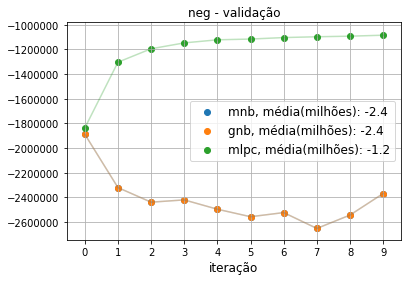

In [79]:
#Visualizar
plotScores(clf_s, ['test_neg_mean_squared_error'],'classifiers.png', False)

### 4.  Realização da predição da submission
Pelas comparações acima ficou claro que o problema é de regressão, e a técnica que a apresentou melhores resultados foi "LinearRegression". A mesma é usada para a previsão.

In [63]:
# A extração das features das submissions foi feita no mesmo tempo das do treino

In [75]:
#Verificar o tamanho matriz
print(X_submission.shape)

(508438, 7)


In [76]:
def predictSubmission(clf, X_sub):
    """
    Entrada:
    Saída:
    """
    y_sub=clf.predict(X_sub)
    #print(y_sub.shape)
    y_list=list(y_sub)
    y_list2=[]
    for i in range(0,len(y_list)):
        proba=y_list[i]
        if proba<0.0:
            y_list2.append(0.0)
        elif proba>1.0:
            y_list2.append(1.0)
        else:
            y_list2.append(proba)
    
    return np.array(y_list2)

In [77]:
#Prever as probabilidades com o melhor clf
clf=joblib.load('lreg_7feats.pkl') #Ler o modelo salvo acima
y_submission_=predictSubmission(clf,X_submission)
print(y_submission_.shape)

(508438,)


In [78]:
df_submission= pd.DataFrame(
    {'deal_probability': y_submission_}, 
    index=df_test['item_id'])
#Alteraçao das faixas de probabilidades
df_submission.to_csv('sub_7feat_29_alg2V08_1.csv')
df_submission.head()

,deal_probability
item_id,
6544e41a8817,0.098577
65b9484d670f,0.233571
8bab230b2ecd,0.192862
8e348601fefc,0.260536
8bd2fe400b89,0.249443


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000B7885387F0>]],
      dtype=object)

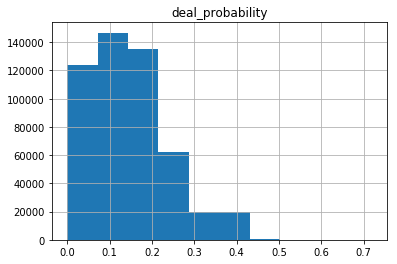

In [79]:
df_submission.hist()

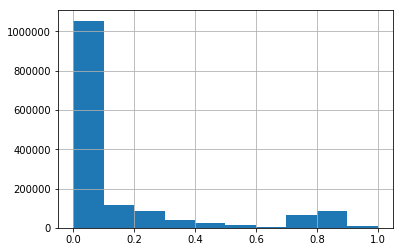

In [323]:
df_train['deal_probability'].hist()

In [324]:
df_submission.describe()

,deal_probability
count,508438.000000
mean,0.143335
std,0.091869
min,0.000000
25%,0.070681
50%,0.131711
75%,0.206757
max,0.606282


In [325]:
train=df_train[['deal_probability']]
round(train.describe(),3)

,deal_probability
count,1503424.000
mean,0.139
std,0.260
min,0.000
25%,0.000
50%,0.000
75%,0.151
max,1.000


Alguns links consultados no trabalho:
* http://scikit-learn.org/stable/modules/model_evaluation.html#scoring
* http://scikit-learn.org/stable/modules/cross_validation.html